In [12]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from PIL import Image
from skimage import color
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor, gabor_kernel
from tqdm import tqdm

from utils.types import FeatureMatrix_float64, FeatureVector_float32, RGBImage_uint8

In [ ]:
def load_split(
    split_dir: str,
) -> tuple[list[NDArray[np.uint8]], NDArray[np.uint8]]:
    """Load 5 images each from REAL and FAKE directories using PIL."""
    images = []
    labels = []

    for label_name, label_value in [("REAL", 0), ("FAKE", 1)]:
        class_dir = Path(split_dir) / label_name
        if not class_dir.is_dir():
            msg = f"Directory not found: {class_dir}"
            raise RuntimeError(msg)

        img_paths = list(class_dir.glob("*.jpg"))[5:10]
        for img_path in img_paths:
            img = np.array(Image.open(img_path).convert("RGB"))
            images.append(img)
            labels.append(label_value)

    return images, np.array(labels, dtype=np.uint8)


train_images, train_labels = load_split("data/train")

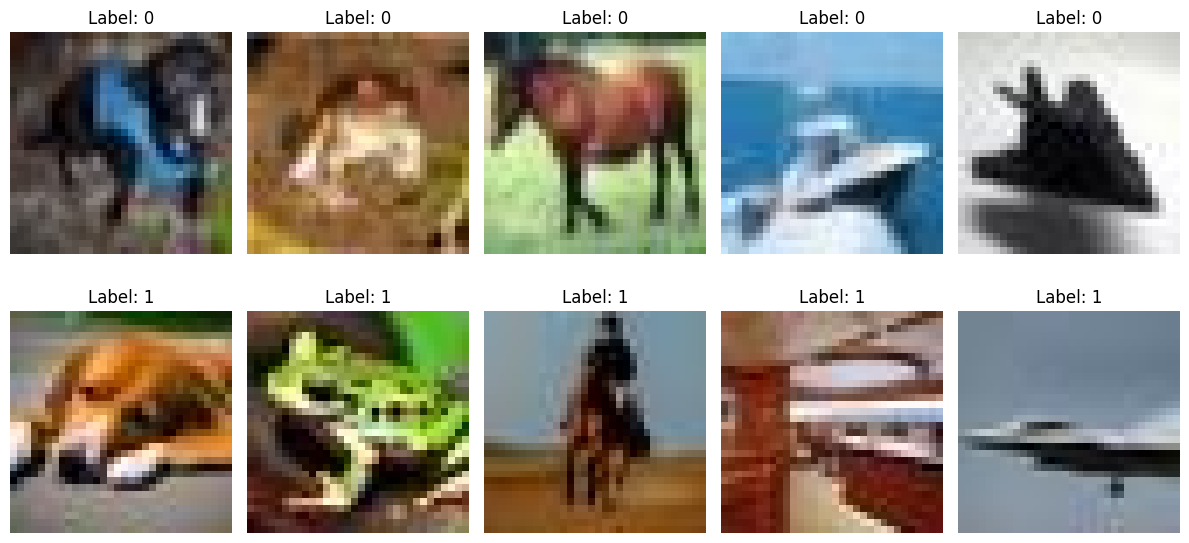

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i])
    ax.axis("off")
    ax.set_title(f"Label: {train_labels[i]}")
plt.tight_layout()
plt.show()

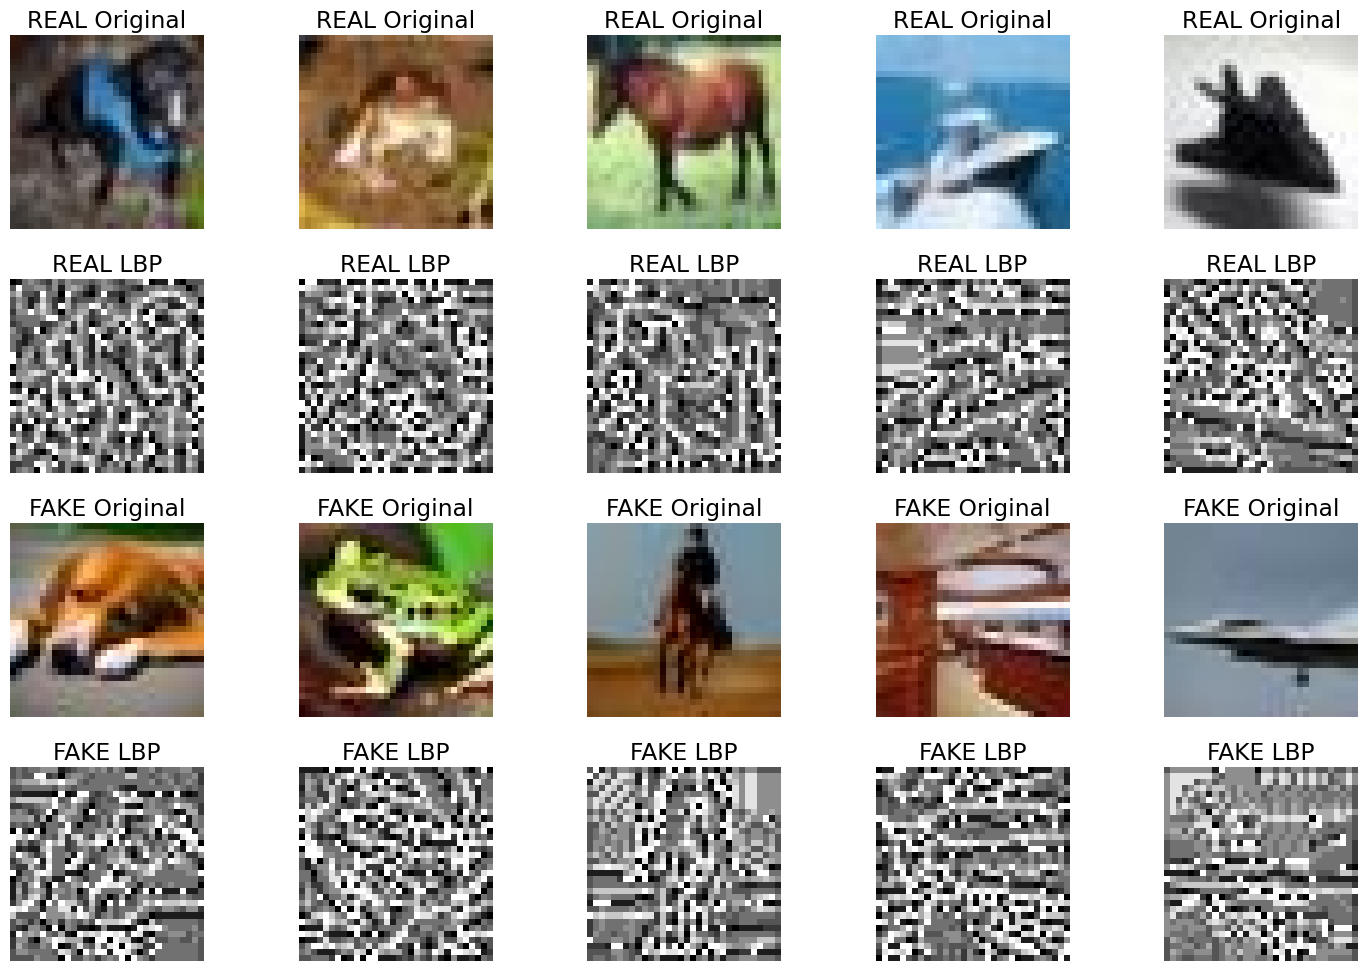

In [ ]:
lbp_images = []
for img in train_images:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_images.append(lbp)

fig, axes = plt.subplots(4, 5, figsize=(15, 10))

# First row: original images (REAL)
for i in range(5):
    axes[0, i].imshow(train_images[i])
    axes[0, i].axis("off")
    axes[0, i].set_title("REAL Original")

# Second row: LBP images (REAL)
for i in range(5):
    axes[1, i].imshow(lbp_images[i], cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title("REAL LBP")

# Third row: original images (FAKE)
for i in range(5, 10):
    axes[2, i - 5].imshow(train_images[i])
    axes[2, i - 5].axis("off")
    axes[2, i - 5].set_title("FAKE Original")

# Fourth row: LBP images (FAKE)
for i in range(5, 10):
    axes[3, i - 5].imshow(lbp_images[i], cmap="gray")
    axes[3, i - 5].axis("off")
    axes[3, i - 5].set_title("FAKE LBP")

plt.rcParams.update({"font.size": 16})
plt.tight_layout()
plt.show()

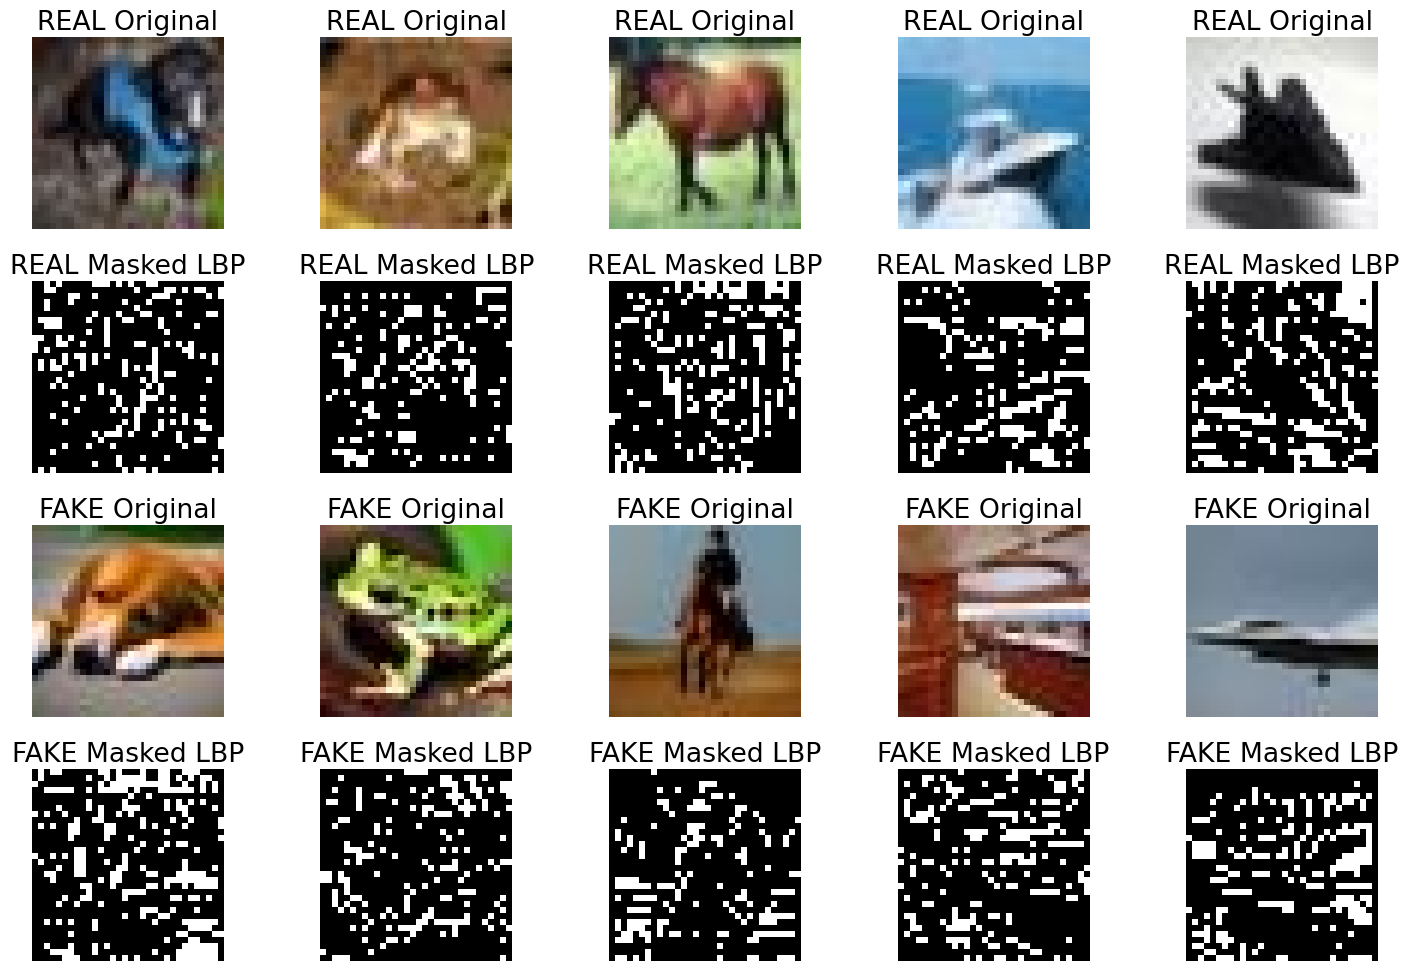

In [51]:
masked_lbp_images = [(lbp_img == 4).astype(float) * 4 for lbp_img in lbp_images]

fig, axes = plt.subplots(4, 5, figsize=(15, 10))

# First row: original images (REAL)
for i in range(5):
    axes[0, i].imshow(train_images[i])
    axes[0, i].axis("off")
    axes[0, i].set_title("REAL Original")

# Second row: masked LBP images (REAL)
for i in range(5):
    axes[1, i].imshow(masked_lbp_images[i], cmap="gray", vmin=0, vmax=4)
    axes[1, i].axis("off")
    axes[1, i].set_title("REAL Masked LBP")

# Third row: original images (FAKE)
for i in range(5, 10):
    axes[2, i - 5].imshow(train_images[i])
    axes[2, i - 5].axis("off")
    axes[2, i - 5].set_title("FAKE Original")

# Fourth row: masked LBP images (FAKE)
for i in range(5, 10):
    axes[3, i - 5].imshow(masked_lbp_images[i], cmap="gray", vmin=0, vmax=4)
    axes[3, i - 5].axis("off")
    axes[3, i - 5].set_title("FAKE Masked LBP")

plt.rcParams.update({"font.size": 16})
plt.tight_layout()
plt.show()


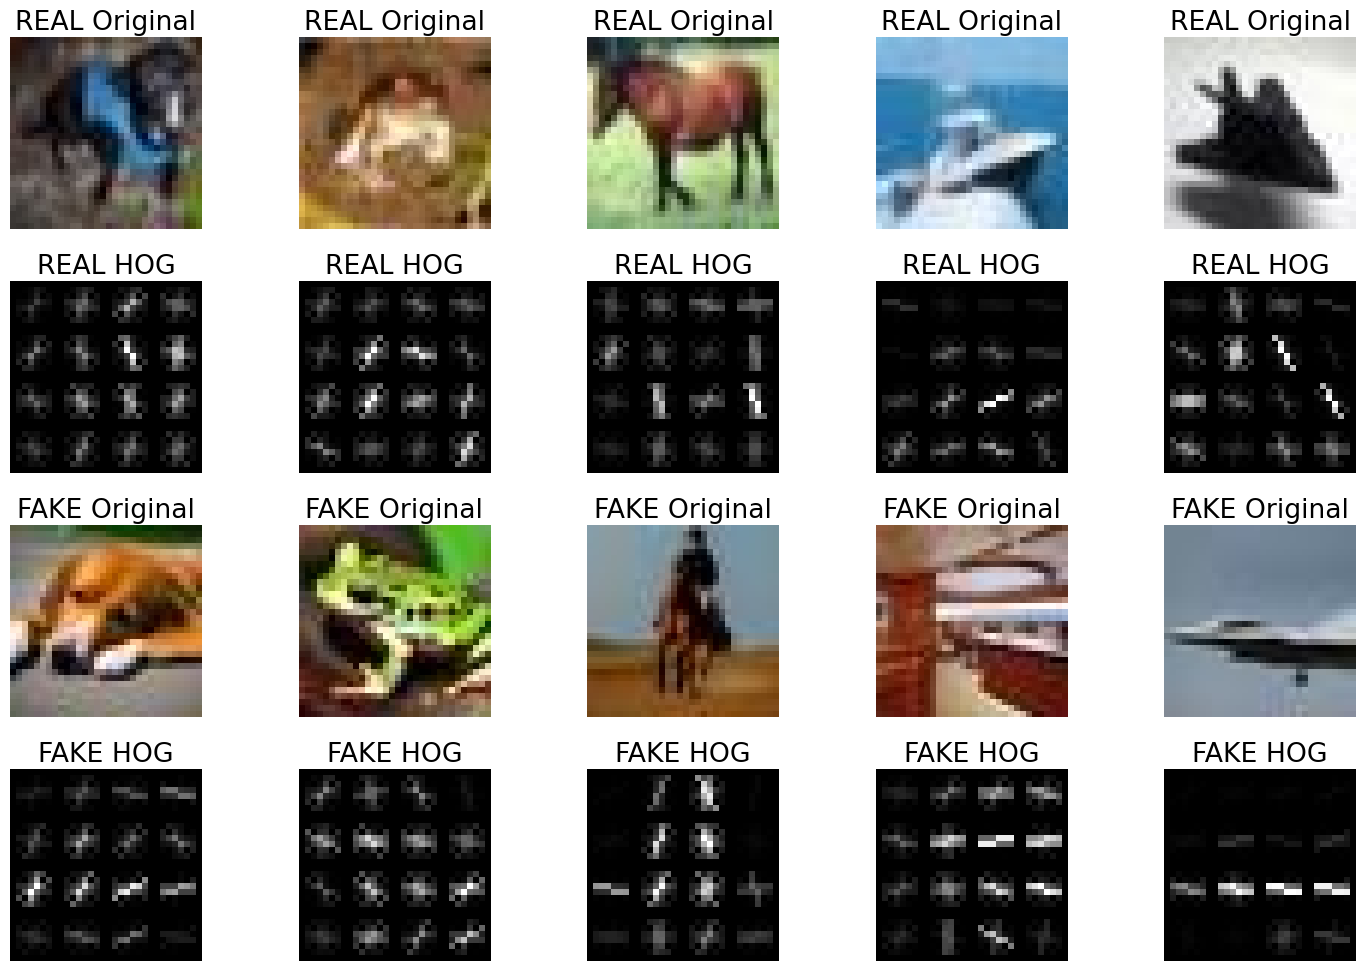

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
for i in range(10):
    gray = cv2.cvtColor(train_images[i], cv2.COLOR_RGB2GRAY)
    _, hog_image = hog(
        gray,
        orientations=8,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2",
        visualize=True,
        feature_vector=True,
    )
    row = 0 if i < 5 else 2
    col = i if i < 5 else i - 5
    axes[row, col].imshow(train_images[i])
    axes[row, col].axis("off")
    axes[row, col].set_title(f"{'REAL' if train_labels[i] == 0 else 'FAKE'} Original")
    axes[row + 1, col].imshow(hog_image, cmap="gray")
    axes[row + 1, col].axis("off")
    axes[row + 1, col].set_title(f"{'REAL' if train_labels[i] == 0 else 'FAKE'} HOG")
plt.rcParams.update({"font.size": 16})
plt.tight_layout()
plt.show()


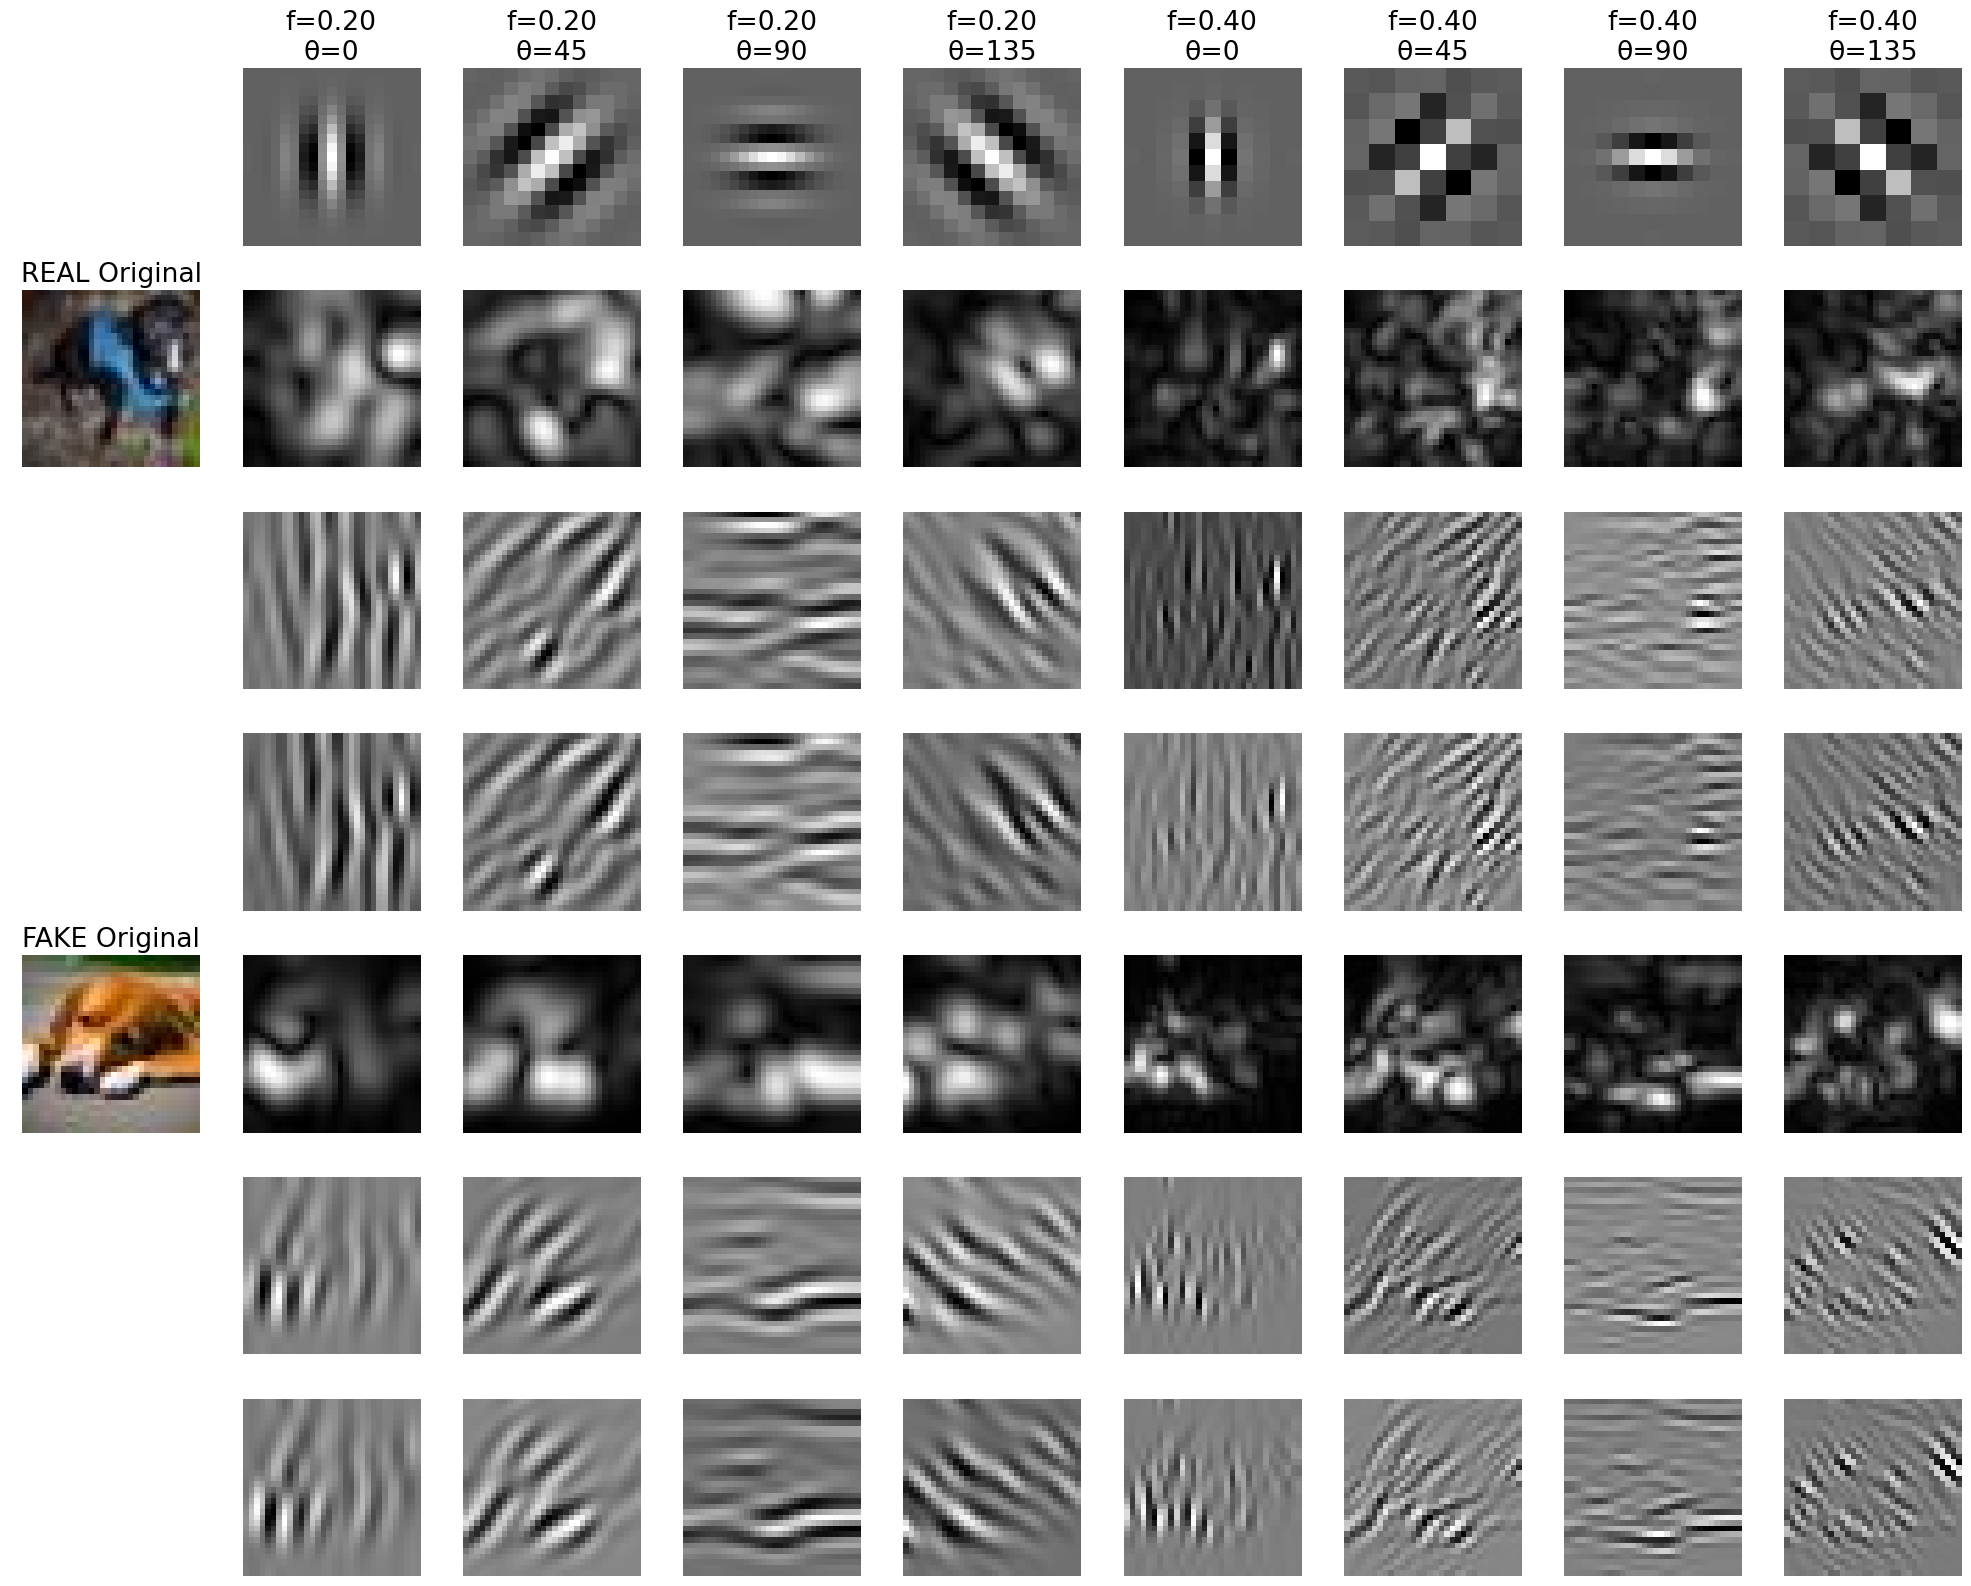

In [ ]:
real_idx = 0
fake_idx = 5

frequencies = [0.2, 0.4]
thetas = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]

# grayscale
gray_real = color.rgb2gray(train_images[real_idx]).astype(np.float32)
gray_fake = color.rgb2gray(train_images[fake_idx]).astype(np.float32)

# prepare kernel list (8 kernels)
kernel_params = [(f, t) for f in frequencies for t in thetas][:8]

# final figure
fig, axes = plt.subplots(7, 9, figsize=(20, 16))

# COLUMN 1 special elements
# row2 REAL original
axes[1, 0].imshow(train_images[real_idx])
axes[1, 0].set_title("REAL Original")
axes[1, 0].axis("off")

# row5 FAKE original
axes[4, 0].imshow(train_images[fake_idx])
axes[4, 0].set_title("FAKE Original")
axes[4, 0].axis("off")

# processing
for i, (freq, theta) in enumerate(kernel_params):
    col = i + 1  # columns 1 to 8 mapped to 2 to 9

    # -----------------
    # Kernel row
    # -----------------
    kernel = gabor_kernel(freq, theta=theta)
    axes[0, col].imshow(np.real(kernel), cmap="gray")
    axes[0, col].set_title(f"f={freq:.2f}\nθ={np.rad2deg(theta):.0f}")
    axes[0, col].axis("off")

    # -----------------
    # REAL responses
    # -----------------
    real_resp, imag_resp = gabor(gray_real, frequency=freq, theta=theta)
    magnitude_real = np.sqrt(real_resp**2 + imag_resp**2)

    # row2 magnitude
    axes[1, col].imshow(magnitude_real, cmap="gray")
    axes[1, col].axis("off")

    # row3 real part
    axes[2, col].imshow(real_resp, cmap="gray")
    axes[2, col].axis("off")

    # row4 imaginary part
    axes[3, col].imshow(imag_resp, cmap="gray")
    axes[3, col].axis("off")

    # -----------------
    # FAKE responses
    # -----------------
    real_resp_f, imag_resp_f = gabor(gray_fake, frequency=freq, theta=theta)
    magnitude_fake = np.sqrt(real_resp_f**2 + imag_resp_f**2)

    # row5 magnitude
    axes[4, col].imshow(magnitude_fake, cmap="gray")
    axes[4, col].axis("off")

    # row6 real part
    axes[5, col].imshow(real_resp_f, cmap="gray")
    axes[5, col].axis("off")

    # row7 imaginary part
    axes[6, col].imshow(imag_resp_f, cmap="gray")
    axes[6, col].axis("off")

# Turn off unused axes in column 0 except originals
for r in [0, 2, 3, 5, 6]:
    axes[r, 0].axis("off")

# make text bigger
plt.rcParams.update({"font.size": 12})
plt.tight_layout()
plt.show()


In [ ]:
def load_split_new(
    split_dir: str,
) -> tuple[list[NDArray[np.uint8]], NDArray[np.uint8]]:
    """Load images from REAL and FAKE directories and resize to 32 x 32 with bilinear interpolation."""

    images: list[NDArray[np.uint8]] = []
    labels: list[int] = []

    for label_name, label_value in [("REAL", 0), ("FAKE", 1)]:
        class_dir = Path(split_dir) / label_name
        if not class_dir.is_dir():
            msg = f"Directory not found: {class_dir}"
            raise RuntimeError(msg)

        img_paths = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.jpeg"))

        for img_path in img_paths:
            img = Image.open(img_path).convert("RGB")
            img = img.resize((32, 32), resample=Image.BILINEAR)
            img_array = np.array(img, dtype=np.uint8)

            images.append(img_array)
            labels.append(label_value)

    return images, np.array(labels, dtype=np.uint8)


new_images, new_labels = load_split_new("data/new_images")

In [7]:
len(new_images), new_images[0].shape, len(new_labels)

(10, (32, 32, 3), 10)

In [13]:
def extract_lbp(img: RGBImage_uint8, p: int, r: float, method: str) -> FeatureVector_float32:
    """Extract LBP histogram from an image."""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lbp: FeatureMatrix_float64 = local_binary_pattern(gray, P=p, R=r, method=method)
    # lbp shape = (h, w)
    if method == "default":
        n_bins = 2**p
    elif method == "uniform":  # --> Each pixel has an LBP code in 0 to 9
        n_bins = p + 2  # e.g., p=8 --> 10 bins
    elif method == "nri_uniform":
        n_bins = p * (p - 1) + 3
    else:
        n_bins = int(lbp.max() + 1)

    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist.astype(np.float32)


def extract_hog_feature(
    img: RGBImage_uint8,
    orientations: int,
    pixels_per_cell: tuple[int, int],
    cells_per_block: tuple[int, int],
) -> FeatureVector_float32:
    """Extract Histogram of Oriented Gradients (HOG) features from a grayscale image."""
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    feat = hog(
        gray,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm="L2",
        feature_vector=True,
    )
    return feat.astype(np.float32)


GABOR_FREQUENCIES = [0.2, 0.4]
GABOR_THETAS = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]


def extract_gabor_feature(img: RGBImage_uint8, frequency: float, theta: float) -> tuple[float, float]:
    """Return stacked mean/std magnitudes of the configured Gabor responses."""
    gray = color.rgb2gray(img).astype(np.float32)

    real, imag = gabor(gray, frequency=frequency, theta=theta)
    magnitude = np.sqrt(real**2 + imag**2)

    return float(magnitude.mean()), float(magnitude.std())


def get_gabor_df(images: list[RGBImage_uint8]) -> pd.DataFrame:
    features = {}
    for frequency in GABOR_FREQUENCIES:
        for theta in GABOR_THETAS:
            means = []
            stds = []
            for img in tqdm(images, desc=f"Gabor freq={frequency} theta={np.rad2deg(theta)}"):
                mean, std = extract_gabor_feature(img, frequency, theta)
                means.append(mean)
                stds.append(std)
            features[f"gabor_f{frequency}_t{np.rad2deg(theta)}_mean"] = means
            features[f"gabor_f{frequency}_t{np.rad2deg(theta)}_std"] = stds
    return pd.DataFrame(features)


def extract_color_hist_rgb(img: RGBImage_uint8, color_bins: int) -> pd.DataFrame:
    """Concatenate per-channel normalized histograms."""
    reds = img[..., 0].ravel()
    greens = img[..., 1].ravel()
    blues = img[..., 2].ravel()
    red_hist, _ = np.histogram(reds, bins=color_bins, range=(0, 255), density=True)
    green_hist, _ = np.histogram(greens, bins=color_bins, range=(0, 255), density=True)
    blue_hist, _ = np.histogram(blues, bins=color_bins, range=(0, 255), density=True)
    red_df = pd.DataFrame(red_hist).T.add_prefix("red_hist_")
    green_df = pd.DataFrame(green_hist).T.add_prefix("green_hist_")
    blue_df = pd.DataFrame(blue_hist).T.add_prefix("blue_hist_")
    return pd.concat([red_df, green_df, blue_df], axis=1)


def extract_rgb_histograms_df(images: list[RGBImage_uint8], color_bins: int = 16) -> pd.DataFrame:
    """Extract RGB histograms for a list of images and return as a DataFrame."""
    histograms = []
    for img in tqdm(images, desc="Extracting RGB histograms"):
        hist_df = extract_color_hist_rgb(img, color_bins)
        histograms.append(hist_df)
    return pd.concat(histograms, ignore_index=True)


def extract_color_hist_hsv_3d(
    img: RGBImage_uint8,
    h_bins: int = 8,
    s_bins: int = 4,
    v_bins: int = 4,
) -> pd.DataFrame:
    """
    Compute 3D HSV histogram (H x S x V) and return as a labeled DataFrame.
    Example: 8 x 4 x 4 → 128 features with columns: hsv_h0_s0_v0, ...
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h = hsv[..., 0].astype(np.float32)
    s = hsv[..., 1].astype(np.float32)
    v = hsv[..., 2].astype(np.float32)
    pixels = np.stack([h.ravel(), s.ravel(), v.ravel()], axis=1)
    hist, _ = np.histogramdd(
        pixels,
        bins=(h_bins, s_bins, v_bins),
        range=((0, 180), (0, 256), (0, 256)),
    )
    hist = hist / (hist.sum() + 1e-8)
    flat = hist.flatten()
    columns = [f"hsv_h{hi}_s{si}_v{vi}" for hi in range(h_bins) for si in range(s_bins) for vi in range(v_bins)]
    return pd.DataFrame([flat], columns=columns, dtype=np.float32)


def extract_hsv_histograms_df(
    images: list[RGBImage_uint8],
    h_bins: int = 8,
    s_bins: int = 4,
    v_bins: int = 4,
) -> pd.DataFrame:
    """Loop through images and return a DataFrame of HSV histograms."""
    dfs = [
        extract_color_hist_hsv_3d(img, h_bins, s_bins, v_bins) for img in tqdm(images, desc="Extracting HSV histograms")
    ]
    return pd.concat(dfs, ignore_index=True)


# Extract all features for new_images and combine into a single DataFrame with labels

# LBP features
lbp_df = pd.DataFrame([extract_lbp(img, p=8, r=1, method="uniform") for img in new_images])
lbp_df.columns = [f"lbp_{i}" for i in range(lbp_df.shape[1])]

# HOG features
hog_df = pd.DataFrame(
    [extract_hog_feature(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)) for img in new_images],
)
hog_df.columns = [f"hog_{i}" for i in range(hog_df.shape[1])]

# Gabor features
gabor_df = get_gabor_df(new_images)
gabor_df.columns = gabor_df.columns.str.replace(".0_", "_")

# RGB histogram features
rgb_df = extract_rgb_histograms_df(new_images)

# HSV histogram features
hsv_df = extract_hsv_histograms_df(new_images)

# Combine all features
features_df = pd.concat([lbp_df, hog_df, gabor_df, rgb_df, hsv_df], axis=1)
features_df["label"] = new_labels


Gabor freq=0.2 theta=0.0:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting HSV histograms: 100%|██████████| 10/10 [00:00<00:00, 1008.00it/s]


In [14]:
features_df

,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9,...,hsv_h7_s1_v3,hsv_h7_s2_v0,hsv_h7_s2_v1,hsv_h7_s2_v2,hsv_h7_s2_v3,hsv_h7_s3_v0,hsv_h7_s3_v1,hsv_h7_s3_v2,hsv_h7_s3_v3,label
0,0.054688,0.084961,0.077148,0.132812,0.189453,0.139648,0.074219,0.070312,0.086914,0.089844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.040039,0.073242,0.083008,0.152344,0.225586,0.162109,0.075195,0.043945,0.055664,0.088867,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.031250,0.055664,0.020508,0.064453,0.453125,0.180664,0.023438,0.033203,0.071289,0.066406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.058594,0.093750,0.074219,0.125000,0.209961,0.140625,0.063477,0.083008,0.048828,0.102539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.029297,0.073242,0.060547,0.162109,0.352539,0.119141,0.052734,0.059570,0.034180,0.056641,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.051758,0.098633,0.066406,0.125977,0.206055,0.124023,0.083008,0.065430,0.083008,0.095703,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.039062,0.072266,0.079102,0.146484,0.241211,0.166016,0.065430,0.049805,0.050781,0.089844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.036133,0.058594,0.024414,0.058594,0.444336,0.183594,0.022461,0.033203,0.063477,0.075195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0.064453,0.087891,0.079102,0.146484,0.170898,0.128906,0.083984,0.065430,0.057617,0.115234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,0.032227,0.068359,0.058594,0.155273,0.371094,0.122070,0.041992,0.059570,0.032227,0.058594,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [15]:
import joblib

loaded_ml = joblib.load("outputs/models/All/LGBMClassifier.joblib")

In [16]:
X_test = features_df.drop(columns=["label"])
y_test = features_df["label"]

In [17]:
from sklearn.metrics import classification_report

y_pred = loaded_ml.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["REAL", "FAKE"], digits=4, zero_division=0))

              precision    recall  f1-score   support

        REAL     0.5000    1.0000    0.6667         5
        FAKE     0.0000    0.0000    0.0000         5

    accuracy                         0.5000        10
   macro avg     0.2500    0.5000    0.3333        10
weighted avg     0.2500    0.5000    0.3333        10

